# Improving Neural Net Performance

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    """
    Prepare input features from CA housing data set
    
    Args:
        california_housing_dataframe: A 'DataFrame' containing the CA housing data set
    Returns:
        'DataFrame' containing the features to be used for the model, including synthetic features
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

In [3]:
def preprocess_targets(california_housing_dataframe):
    """
    Prepare target features from CA housing data set
    
    Args:
        california_housing_dataframe: A 'DataFrame' containing CA housing data set
    Returns:
        A 'DataFrame' containing the target frame
    """
    
    df = pd.DataFrame()
    df["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return df

In [4]:
# split data into training / validation
training_examples = preprocess_features(california_housing_dataframe).head(12000)
training_targets = preprocess_targets(california_housing_dataframe).head(12000)

validation_examples = preprocess_features(california_housing_dataframe).tail(5000)
validation_targets = preprocess_targets(california_housing_dataframe).tail(5000)

print("Training example summary")
display.display(training_examples.describe())
print("Validation example summary")
display.display(validation_examples.describe())
print("Training target summary")
display.display(training_targets.describe())
print("Validation target summary")
display.display(validation_targets.describe())

Training example summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2647.4,540.3,1428.6,501.7,3.9,2.0
std,2.1,2.0,12.6,2186.2,421.2,1143.5,383.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1465.0,296.0,784.8,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2118.0,433.0,1168.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3161.2,649.0,1720.0,606.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation example summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2634.7,537.3,1431.9,500.2,3.9,2.0
std,2.1,2.0,12.5,2165.0,422.3,1158.2,387.4,2.0,1.0
min,32.6,-124.3,1.0,12.0,4.0,3.0,4.0,0.5,0.0
25%,33.9,-121.8,18.0,1451.0,299.0,799.0,283.0,2.5,1.5
50%,34.2,-118.5,29.0,2151.0,435.0,1166.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3124.5,648.0,1725.0,605.0,4.8,2.3
max,42.0,-114.6,52.0,32627.0,6445.0,28566.0,6082.0,15.0,29.4


Training target summary


,median_house_value
count,12000.0
mean,206.9
std,115.6
min,15.0
25%,120.0
50%,180.5
75%,263.8
max,500.0


Validation target summary


,median_house_value
count,5000.0
mean,208.3
std,116.9
min,15.0
25%,118.8
50%,179.8
75%,268.8
max,500.0


## Train Neural Network

In [5]:
def construct_feature_columns(input_features):
    """
    Construct the TennsorFlow input feature columns.
    
    Args:
        input_features: Names of the numerical input features to use
    Returns:
        Set of feature columns
    """
    return set([tf.feature_column.numeric_column(feature) for feature in input_features])

In [10]:
def my_input_fn(features, targets, batch_size=1, num_epochs=None, shuffle=True):
    """
    Train a neural network model
    
    Args:
        features: 'DataFrame' of input features
        targets: 'DataFrame' of targets
        batch_size: Size of batches to pass into model
        num_epochs: Number of epochs to pass through the data, None = repeat indefinitely
        shuffle: True of False, whether to shuffle the data
    Returns:
        A tuple (features,targets)
    """
    
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds.shuffle(10000)
        
    features, targets = ds.make_one_shot_iterator().get_next()
    return features, targets

In [11]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    target_col = "median_house_value"
    
    # create optimizer
    my_opt = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units, 
        optimizer=my_opt)
    
    # create input fns
    training_input_fn = lambda: my_input_fn(training_examples, training_targets[target_col], 
                                            batch_size=batch_size)
    predictions_training_input_fn = lambda: my_input_fn(training_examples, training_targets[target_col],
                                                       num_epochs=1, shuffle=False)
    predictions_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets[target_col],
                                                         num_epochs=1, shuffle=False)
    training_rmse = []
    validation_rmse = []
    print("Training model...")
    print("RMSE (training):")
    for period in range(0, periods):
        dnn_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # make predictions
        training_predictions = dnn_regressor.predict(predictions_training_input_fn)
        training_predictions = np.array([item["predictions"] for item in training_predictions])
        validation_predictions = dnn_regressor.predict(predictions_validation_input_fn)
        validation_predictions = np.array([item["predictions"] for item in validation_predictions])
        # calculate rmse
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_targets, training_predictions))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_targets, validation_predictions))
        # print metrics for period
        print("  %02d : %0.2f" % (period, validation_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model finished training")
    
    # plot loss metrics
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("RMSE vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    print("Final RMSE (training): %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (validation: %0.2f" % validation_root_mean_squared_error)
    
    return dnn_regressor

Training model...
RMSE (training):
  00 : 166.88
  01 : 155.72
  02 : 143.74
  03 : 129.45
  04 : 119.04
  05 : 114.22
  06 : 112.60
  07 : 111.90
  08 : 111.27
  09 : 111.32
Model finished training
Final RMSE (training): 111.65
Final RMSE (validation: 111.32


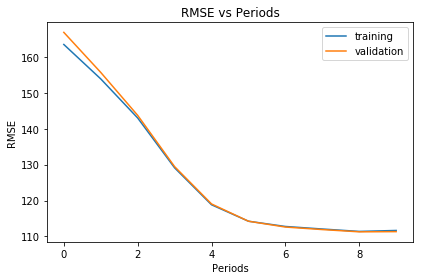

In [12]:
_ = train_nn_regression_model(
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=50,
    hidden_units=[10,10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Linear Scaling

In [14]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x-min_val) / scale) - 1.0)

## Task 1: Normalize Features using Linear Scaling

In [16]:
def normalize_linear_scale(examples_dataframe):
    """
    Returns a version of the input 'DataFrame' that has all features normalized linearly
    """
    return examples_dataframe.apply(lambda x: linear_scale(x))

In [21]:
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

Training model...
RMSE (training):
  00 : 156.31
  01 : 113.72
  02 : 97.80
  03 : 79.73
  04 : 75.00
  05 : 72.88
  06 : 71.75
  07 : 71.07
  08 : 70.60
  09 : 70.24
Model finished training
Final RMSE (training): 69.95
Final RMSE (validation: 70.24


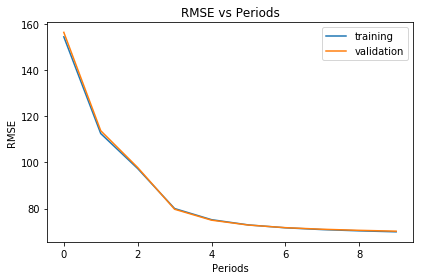

In [22]:
_ = train_nn_regression_model(
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=100,
    hidden_units=[10,10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)